In [ ]:
!pip install feedparser

In [ ]:
import csv
import time
import feedparser
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import ast
import random
from openai import OpenAI

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

In [ ]:
import base64
import os
from google import genai
from google.genai import types

In [ ]:
!pip install anthropic
import anthropic

# Read file

In [ ]:
def read_df (df):
    col_lst = df.columns.tolist()
    col_filtered = [col for col in col_lst if col not in ['arXiv_ID', 'Title', 'Published', 'Abstract', 'keywords', 'llama_1/2_amb', 'gemini_1/2_amb', 'claude_1/2_amb', 'ds_1/2_amb', 'gpt_1/2_amb']]
    for col in col_filtered:
        def safe_literal_eval(x):
            if isinstance(x, str):
                try:
                    return ast.literal_eval(x)
                except Exception as e:
                    print(f"Error in column '{col}' for value: {x}")
                    return x  # or return None, depending on desired behavior
            return x

        df[col] = df[col].apply(safe_literal_eval)

    return df

In [ ]:
def remove_np_float_values(x):
    """
    If x is a string containing 'np.float...' calls, remove them and
    convert the resulting string to a Python object.
    """
    if isinstance(x, str):
        # This regex captures numeric content inside np.float32(...), np.float64(...), etc.
        cleaned = re.sub(r'np\.float[0-9]*\(([^)]+)\)', r'\1', x)
        try:
            return ast.literal_eval(cleaned)
        except (SyntaxError, ValueError):
            # If literal_eval fails, just return the cleaned string
            return cleaned
    return x

# sBERT

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load a Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# LLMs-APIs

In [ ]:
def llm_api (prompt, model = "llama3.3-70b", max_completion_tokens =1000):


    if model == "llama3.3-70b":

        client = OpenAI(
        api_key="api_key_here",
        base_url="https://api.llama-api.com/"
        )
        response = client.chat.completions.create(
            model=model,
            messages=[
            {
                "role": "system",
                "content": "You are a researcher responsible for drafting the paper's abstract."
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        temperature=0,
        max_completion_tokens=max_completion_tokens,
        top_p=1,
        stream=False,
        stop=None,
        seed = 1
        )

        response_text = response.choices[0].message.content

    # Deepseek-chat
    elif model == "deepseek-chat":

        client = OpenAI(
            api_key="api_key_here", 
            base_url="https://api.deepseek.com")

        response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a researcher responsible for drafting the paper's abstract."
                },
            {
                "role": "user",
                "content": prompt
                },
        ],
        stream=False,
        temperature=0,
        max_tokens=max_completion_tokens,
        top_p=1,
        stop=None,
        seed = 1
        )
        if response is None:
            response_text = ""
            print(response)
            # raise Exception("Response is None")
        else:
            response_text = response.choices[0].message.content

    elif model == "gemini-2.0-flash":
        client = genai.Client(
        api_key="api_key_here",)

        response = client.models.generate_content(
            model=model,
            contents=[prompt],
            config=types.GenerateContentConfig(
                temperature=0,
                top_p=1,
                top_k=40,
                max_output_tokens = max_completion_tokens,
                response_mime_type="text/plain",
                system_instruction = "You are a researcher responsible for drafting the paper's abstract.")
        )
        response_text = response.text.replace("...", "").replace("\n", "")

    elif model == "claude-3-7-sonnet-20250219":
        client = anthropic.Anthropic(
            api_key="api_key_here",
        )

        message = client.messages.create(
            model=model,
            max_tokens=max_completion_tokens,
            temperature=0,
            system="You are a researcher responsible for drafting the paper's abstract.",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt
                        }
                    ]
                }])
        response_text = message.content[0].text

    elif model == 'gpt-4o':
        client = OpenAI(
            api_key="api_key_here")

        response = client.chat.completions.create(
        model=model,
        messages=[
            {
            "role": "system",
            "content": [
                {
                "type": "text",
                "text": "You are a researcher responsible for drafting the paper's abstract."
                }
            ]
            },
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": prompt
                }
            ]
            }
        ],
        response_format = {
            "type": "text"
        },
        temperature=0,
        max_completion_tokens=max_completion_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
        )

        response_text = response.choices[0].message.content
    else:
        response_text = "Model not found."




    return response_text

In [ ]:
init_prompt = 'Here is the part of the abstract from arXiv paper, please continue this abstract with full sentences without including the given content in the output.\n\n'
input_tokens = "We present Fillerbuster, a method that completes unknown regions of a 3D scene by utilizing a novel large-scale multi-view latent diffusion transformer. Casual captures are often sparse and miss surrounding content behind objects or above the scene. Existing methods"
prompt = init_prompt + input_tokens
print(prompt)

llama = llm_api (prompt, model = 'llama3.3-70b', max_completion_tokens =1000)
print('***** llama *****')
print(llama)

deepseek = llm_api (prompt, model = 'deepseek-chat', max_completion_tokens =1000)
print('\n***** deepseek *****')
print(deepseek)

gemini = llm_api (prompt, model = 'gemini-2.0-flash', max_completion_tokens =1000)
print('\n***** gemini *****')
print(gemini)

claude = llm_api (prompt, model = 'claude-3-7-sonnet-20250219', max_completion_tokens =1000)
print('\n***** claude *****')
print(claude)

gpt = llm_api (prompt, model = 'gpt-4o', max_completion_tokens =1000)
print('\n***** gpt *****')
print(gpt)


Here is the part of the abstract from arXiv paper, please continue this abstract with full sentences without including the given content in the output.

We present Fillerbuster, a method that completes unknown regions of a 3D scene by utilizing a novel large-scale multi-view latent diffusion transformer. Casual captures are often sparse and miss surrounding content behind objects or above the scene. Existing methods
***** llama *****
often rely on simplistic assumptions or hand-designed priors to fill in the missing regions, which can lead to unrealistic or inconsistent completions. In contrast, our approach leverages the power of latent diffusion models to generate high-quality, context-aware completions that respect the underlying 3D structure of the scene. By learning to represent the scene as a probabilistic distribution over a latent space, Fillerbuster can effectively capture complex relationships between visible and occluded regions, resulting in more accurate and coherent compl

# RAG (Customized)

In [ ]:
!pip install -U langchain-huggingface
!pip install -U langchain-community
!pip install arxiv
!pip install pymupdf
!pip install faiss-cpu
!pip install PyPDF2
!pip install --upgrade PyPDF2

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
import arxiv
import requests
import io
import PyPDF2
import re
from PyPDF2 import PdfReader
from io import BytesIO

## Step 1: Retrieve a paper from arXiv

In [ ]:
from io import BytesIO
import requests
from PyPDF2 import PdfReader

def get_full_text(arxiv_id):
    # Construct the direct PDF URL
    pdf_url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"
    # print(f"Downloading PDF from: {pdf_url}")

    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    for _ in range(5):  # Try up to 5 times
        try:
            response = requests.get(pdf_url, headers=headers, timeout=15)
            response.raise_for_status()
        except requests.RequestException as e:
            print(f"Error fetching PDF: {e}")
            time.sleep(1)
            continue

        # Convert bytes to a stream and read with PyPDF2
        try:
            pdf_stream = BytesIO(response.content)
            reader = PdfReader(pdf_stream)
            full_text = ""
            for page in reader.pages:
                page_text = page.extract_text()
                if page_text:
                    page_text_clean = page_text.replace('\n', ' ')
                    full_text += page_text_clean + "\n"
            return full_text
        except Exception as e:
            print(f"Error reading PDF: {e}")
            time.sleep(1)
            continue


## Step 2: Split the full paper into chunks and embeddings

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=1500, chunk_overlap=500, separator = '. ')
chunks = text_splitter.split_text(full_text)
cleaned_chunks = [chunk.encode("utf-8", "ignore").decode("utf-8") for chunk in chunks]
documents = [Document(page_content=chunk) for chunk in cleaned_chunks]


print(f"Number of chunks: {len(chunks)}")
#documents = [Document(page_content=chunk) for chunk in chunks]

vectorstore = FAISS.from_documents(documents, embeddings)

Number of chunks: 45


In [ ]:
def chunk_emb (full_text, chunk_size = 800, chunk_overlap = 200):
    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, separator = '.')
    chunks = text_splitter.split_text(full_text)
    cleaned_chunks = [chunk.encode("utf-8", "ignore").decode("utf-8") for chunk in chunks]
    documents = [Document(page_content=chunk) for chunk in cleaned_chunks]
    vectorstore = FAISS.from_documents(documents, embeddings)
    return vectorstore


## Step 3: Retrieve relevant excerpts from the paper

In [ ]:
user_context = 'In this paper, we investigate the ability of single-layer attention-only transformers (i.e. attention layers) to memorize facts contained in databases from a linear-algebraic perspective. We associate with each database'

retrieved_docs = vectorstore.similarity_search(user_context, k=2)
retrieval_context = "\n".join([doc.page_content for doc in retrieved_docs])
len(retrieval_context)
print(retrieved_docs)

[Document(id='bef014cb-d5d2-4587-b6df-3ec2954af1db', metadata={}, page_content='Paying Attention to Facts: Quantifying the\nKnowledge Capacity of Attention Layers\nLiang Ze Wong\nFebruary 10, 2025\nAbstract\nIn this paper, we investigate the ability of single-layer attention-\nonly transformers (i.e. attention layers) to memorize facts contained\nin databases from a linear-algebraic'), Document(id='e635a587-b9c9-4728-902c-613c5f650cb5', metadata={}, page_content='(i.e. attention layers) to memorize facts contained\nin databases from a linear-algebraic perspective. We associate with each\ndatabase a 3-tensor, propose the rank of this tensor as a measure of the\nsize of the database, and provide bounds on the rank in terms of properties\nof the database. We also')]


# Extract 100 arXiv papers

In [ ]:
from datetime import datetime
import feedparser
import csv

# Define the cutoff date: papers published on or after July 1, 2024
start_date = datetime(2025, 1, 1).date()  # date object with year, month, and day
max_results = 100  # adjust as needed

# -------------------------
# Build the arXiv API query
# -------------------------
# Removed keyword filter by using "all" to fetch all papers
search_query = "all"
base_url = "http://export.arxiv.org/api/query?"
query = (
    f"search_query={search_query}"
    f"&start=0"
    f"&max_results={max_results}"
    f"&sortBy=submittedDate"
    f"&sortOrder=descending"
)
url = base_url + query

print("Fetching data from arXiv API...")
feed = feedparser.parse(url)
print(f"Total results returned: {len(feed.entries)}\n")

# -------------------------
# Prepare CSV file for output
# -------------------------
csv_filename = "file_path/arxiv_papers.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file)
    # Write header row including arXiv_ID
    writer.writerow(["arXiv_ID", "Title", "Published", "Abstract"])

    # -------------------------
    # Process and filter the results
    # -------------------------
    for entry in feed.entries:
        try:
            # Parse the published date (extracting only the date part: year-month-day)
            published_date = datetime.strptime(entry.published, "%Y-%m-%dT%H:%M:%SZ").date()
        except Exception as e:
            print(f"Error parsing date for entry {entry.title}: {e}")
            continue

        # Check if the paper was published on or after the cutoff date
        if published_date >= start_date:
            # Extract arXiv ID from the entry.id (typically in the format 'http://arxiv.org/abs/XXXX.XXXXXvN')
            arxiv_id = entry.id.split('/')[-1]
            title = entry.title
            abstract = entry.summary
            print(f"Saving paper: {title} (arXiv ID: {arxiv_id}, Published: {published_date})")
            writer.writerow([arxiv_id, title, published_date, abstract])

print(f"\nData has been saved to {csv_filename}")


In [ ]:
csv_filename = f"file_path/arxiv_papers.csv"
arxiv_abs = pd.read_csv(csv_filename)

# remove '\n' in the source code
arxiv_abs['Abstract'] = arxiv_abs['Abstract'].str.replace('\n', ' ', regex = False).str.strip()
arxiv_abs['Title'] = arxiv_abs['Title'].str.replace('\n ', '', regex = False).str.strip()

# Input sequence length

In [ ]:
def llm_sim_T_cutoff_ab (abs, arxiv_id1, arxiv_id2, model = 'llama3.3-70b', max_completion_tokens = 1000, k = 3):

    abs_split = abs.split()  # Splits by whitespace (spaces, tabs, newlines)
    cutoff = int((1/2)*len(abs_split))
    range_T = list(range(10, cutoff, 10))

    full_text1 = get_full_text(arxiv_id1)
    vectorstore1 = chunk_emb(full_text1)
    full_text2 = get_full_text(arxiv_id2)
    vectorstore2 = chunk_emb(full_text2)

    llama_results_a = []
    llama_results_ab = []
    cos_llm_t2 = []

    for T in range_T: # increasing the # of input tokens
        input_tokens = ' '.join(abs_split[:T]) # get first T tokens from abstracts

        # Step 1: retrieve information from the full paper
        retrieved_docs1 = vectorstore1.similarity_search(input_tokens, k=k)
        r1 = "\n".join([doc.page_content for doc in retrieved_docs1])
        # print("r1:", r1)
        retrieved_docs2 = vectorstore2.similarity_search(input_tokens, k=k)
        r2 = "\n".join([doc.page_content for doc in retrieved_docs2])
        # print("r2:", r2)

        # Step 2: generated text as hat_a

        combined_prompt_a = f"""Here are some relevant excerpts from research paper(s) as reference:\n{r1}\n\nBelow is the 1st fragment of an abstract from arXiv paper:\n{input_tokens}\n\nPlease continue the 2nd fragment of the abstract based on the relevant excerpts without including the given content in the output."""
        hat_a = llm_api(combined_prompt_a, model = model, max_completion_tokens = max_completion_tokens)

        # Step 3: get generated text as hat_ab

        combined_prompt_ab = f"""Here are some relevant excerpts from research paper(s) as reference:\n{r1}\n{r2}\n\nBelow is the 1st fragment of an abstract from arXiv paper:\n{input_tokens}\n\nPlease continue the 2nd fragment of the abstract based on the relevant excerpts without including the given content in the output."""
        hat_ab = llm_api(combined_prompt_ab, model = model, max_completion_tokens = max_completion_tokens)

        if (not hat_a or not hat_ab):
            cos_llm_t2.append(0)
            llama_results_a.append(hat_a)
            llama_results_ab.append(hat_ab)
            continue
        # Step 4: get the cos_similarity
        emb_hat_ta = sbert_model.encode(hat_a)
        emb_hat_tab = sbert_model.encode(hat_ab)
        cos_llm_t2.append(cosine_similarity([emb_hat_ta], [emb_hat_tab])[0][0]) # similarity hat_a and hat_ab
        llama_results_a.append(hat_a)
        llama_results_ab.append(hat_ab)

    return llama_results_a, llama_results_ab, cos_llm_t2

def T_cutoff_ab_all (df, model):
    cos_llm_t2_all = {}
    llm_t2_all = {}
    # for i in range(len(df)):
    for i in [8]:
        print("i:", i)
        abs = df['Abstract'][i]
        arxiv_id1 = df['arXiv_ID'][i]

        # Randomly select 5 distinct j's
        candidate_js = [j for j in range(len(df)) if j != i]
        selected_js = random.sample(candidate_js, 5)
        print("j: ", selected_js)

        for j in selected_js:

            arxiv_id2 = df['arXiv_ID'][j]
            llama_results_a, llama_results_ab, cos_llm_t2 = llm_sim_T_cutoff_ab(abs, arxiv_id1, arxiv_id2, model = model)
            print(cos_llm_t2)
            cos_llm_t2_all[(i, j)] = cos_llm_t2
            llm_t2_all[(i, j)] = (llama_results_a, llama_results_ab)

    return cos_llm_t2_all, llm_t2_all

## Combine all results

In [ ]:
all_test10 = []
for i in range(10):
    csv_filename = f"file_path/arxiv_papers_10_ab_{i}.csv"
    test10 = pd.read_csv(csv_filename)
    test10['cos_ds_1/2_ab'] = test10['cos_ds_1/2_ab'].apply(remove_np_float_values)
    test10 = test10[['arXiv_ID', 'Title', 'Published', 'Abstract', 'cos_llama_1/2_ab', 'llama_1/2_ab', 'cos_claude_1/2_ab', 'claude_1/2_ab', 'cos_gemini_1/2_ab', 'gemini_1/2_ab', 'cos_gpt_1/2_ab', 'gpt_1/2_ab', 'cos_ds_1/2_ab', 'ds_1/2_ab']].copy()
    test10 = read_df(test10)

    all_test10.append(test10)

test100 = pd.concat(all_test10, ignore_index=True)


## Show the plot

In [ ]:
csv_filename = f"file_path/arxiv_papers_100_ab.csv"
test100 = pd.read_csv(csv_filename)
test100 = read_df(test100)
test100.head(1)

,arXiv_ID,Title,Published,Abstract,cos_llama_1/2_ab,llama_1/2_ab,cos_claude_1/2_ab,claude_1/2_ab,cos_gemini_1/2_ab,gemini_1/2_ab,cos_gpt_1/2_ab,gpt_1/2_ab,cos_ds_1/2_ab,ds_1/2_ab
0,2503.10637v1,Distilling Diversity and Control in Diffusion ...,2025-03-13,Distilled diffusion models suffer from a criti...,"{(0, 7): [0.84126586, 0.9248215, 0.9197989, 0....","{(0, 7): (['diversity compared to their base m...","{(0, 1): [0.845118, 0.9798919, 0.9664083, 0.98...","{(0, 1): (['diversity compared to their base m...","{(0, 2): [0.9437043, 0.9296438, 0.8604546, 0.8...","{(0, 2): (['diversity compared to their base m...","{(0, 7): [0.9739789, 0.92061687, 0.91672707, 0...","{(0, 7): (['Distilled diffusion models, while ...","{(0, 8): [0.93619245, 0.8732753, 0.9294169, 0....","{(0, 8): (['Here’s a refined abstract based on..."


In [ ]:
cols_cos = ['cos_claude_1/2_ab', 'cos_llama_1/2_ab', 'cos_gemini_1/2_ab', 'cos_gpt_1/2_ab', 'cos_ds_1/2_ab']
for col in cols_cos:
    test100[f'{col}_avg'] = test100[col].apply(
        lambda cell: np.mean(list(cell.values()), axis=0).tolist()
        if cell  # Check if the cell is a non-empty dictionary
        else []  # Return empty list for empty cells
    )

# Keep only rows with lengths occurring more than once
length_counts = test100['cos_claude_1/2_ab_avg'].apply(len).value_counts()
valid_lengths = length_counts[length_counts > 0].index    

test100_filtered = test100[test100['cos_claude_1/2_ab_avg'].apply(len).isin(valid_lengths)].reset_index(drop=True)

[ 10  30  50  70  90 110 130 150]


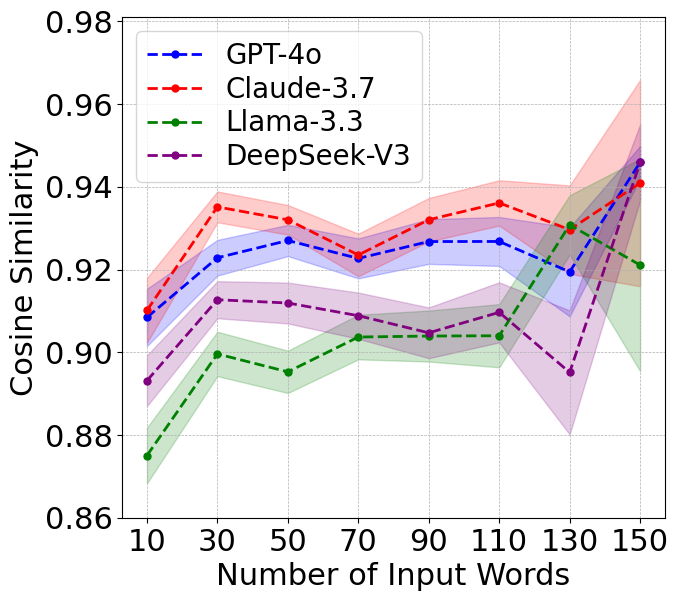

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6.5))
max_length = test100_filtered['cos_claude_1/2_ab_avg'].apply(len).max()
T = np.arange(10, 15 * 10 + 1, 20)
idx = (T - 1) // 10
print(T)

cols_cos_avg = [
    'cos_gpt_1/2_ab_avg',
    'cos_claude_1/2_ab_avg',
    'cos_llama_1/2_ab_avg',
    'cos_ds_1/2_ab_avg'
]

colors = ['blue', 'red', 'green', 'purple', 'orange']
for col, color in zip(cols_cos_avg, colors):
    all_values_per_index = []

    for i in range(max_length):
        values_at_index = [lst[i] for lst in test100_filtered[col] if len(lst) > i]
        all_values_per_index.append(values_at_index)

    new_group_avg = []
    new_group_std_err = []

    for i in idx:
        values = all_values_per_index[i]
        arr = np.array(values)
        mean = np.mean(arr)
        stderr = np.std(arr, ddof=1) / np.sqrt(len(arr))  # standard error

        new_group_avg.append(mean)
        new_group_std_err.append(stderr)

    new_group_avg = np.array(new_group_avg)
    new_group_std_err = np.array(new_group_std_err)

    llm = col.replace('cos_', '').replace('_1/2_ab_avg', '')
    if llm == 'claude':
        label = 'Claude-3.7'
    elif llm == 'llama':
        label = 'Llama-3.3'
    elif llm == 'gemini':
        label = 'Gemini-2.0'
    elif llm == 'gpt':
        label = 'GPT-4o'
    elif llm == 'ds':
        label = 'DeepSeek-V3'

    # Plot mean line
    plt.plot(T, new_group_avg, marker='o', color=color, label=label, markersize=5, linewidth = 2, linestyle = '--')

    # Plot confidence interval as shaded area
    plt.fill_between(T,
                     new_group_avg - new_group_std_err,
                     new_group_avg + new_group_std_err,
                     color=color,
                     alpha=0.2)

plt.xlabel("Number of Input Words", fontsize = 22)
plt.ylabel("Cosine Similarity", fontsize = 22)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.ylim(0.86, 0.981)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize = 20, loc='upper left', ncol=1, labelspacing=0.2)
plt.xticks(np.arange(10, max(T)+1, 20))
plt.show()


# Topic ambiguity

In [ ]:
def llm_sim_amb_cutoff_ab (df, model = 'llama3.3-70b', max_completion_tokens = 1000, k = 3):

    cos_llm_t2_all = {}
    llm_t2_all = {}

    for i in range(len(df)):
        print('i:', i)
        abs_split = df['Abstract'][i].split()  # Splits by whitespace (spaces, tabs, newlines)
        cutoff = int((1/2)*len(abs_split))
        input_tokens = ' '.join(abs_split[:cutoff]) # get first 1/2 tokens from abstracts

        # Step 1: retrieve information from the introduction part
        arxiv_id1 = df['arXiv_ID'][i]
        full_text1 = get_full_text(arxiv_id1)
        vectorstore1 = chunk_emb(full_text1)
        retrieved_docs1 = vectorstore1.similarity_search(input_tokens, k=k)
        r1 = "\n".join([doc.page_content for doc in retrieved_docs1])


        # Step 2: generated text as hat_a
        combined_prompt_a = f"""Here are some relevant excerpts from research paper(s) as reference:\n{r1}\n\nBelow is the 1st fragment of an abstract from arXiv paper:\n{input_tokens}\n\nPlease continue the 2nd fragment of the abstract based on the relevant excerpts without including the given content in the output."""
        hat_a = llm_api(combined_prompt_a, model = model, max_completion_tokens = max_completion_tokens)
        emb_hat_ta = sbert_model.encode(hat_a)

        candidate_js = [j for j in range(len(df)) if j != i]
        selected_js = random.sample(candidate_js, 5) # randomly select 5 papers as topic b
        print("j: ", selected_js)
        for j in selected_js:
            # Step 3: retrieve information from the introduction part
            arxiv_id2 = df['arXiv_ID'][j]
            print(arxiv_id2)
            full_text2 = get_full_text(arxiv_id2)
            vectorstore2 = chunk_emb(full_text2)
            retrieved_docs2 = vectorstore2.similarity_search(input_tokens, k=k)
            r2 = "\n".join([doc.page_content for doc in retrieved_docs2])


            # Step 4: get generated text as hat_ab
            combined_prompt_ab = f"""Here are some relevant excerpts from research paper(s) as reference:\n{r1}\n{r2}\n\nBelow is the 1st fragment of an abstract from arXiv paper:\n{input_tokens}\n\nPlease continue the 2nd fragment of the abstract based on the relevant excerpts without including the given content in the output."""
            hat_ab = llm_api(combined_prompt_ab, model = model, max_completion_tokens = max_completion_tokens)
            emb_hat_tab = sbert_model.encode(hat_ab)

            # Step 5: get the cos_similarity
            cos_llm_t2_all[(i, j)] = cosine_similarity([emb_hat_ta], [emb_hat_tab])[0][0] # similarity hat_a and hat_ab
            llm_t2_all[(i, j)] = (hat_a, hat_ab)

        print(cos_llm_t2_all)

    return cos_llm_t2_all, llm_t2_all

## Generate keywords and get similarity

In [ ]:
def llm_api_keywords (prompt, model = "llama-3.3-70b-specdec", max_completion_tokens =1000):

    client = Groq(
     api_key="api_key_here"
    )

    completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "system",
            "content": "You are a researcher responsible for the academic paper."
        },
        {
            "role": "user",
            "content": 'Here is the abstract from arXiv paper. Please generate 4 keywords based on the following abstract and split keywords with \";\".\n\n'+ prompt
        }
    ],
    temperature=0,
    max_completion_tokens=max_completion_tokens,
    top_p=1,
    stream=True,
    stop=None,
    seed = 1
    )

    response_text = ""

    for chunk in completion:
        content = chunk.choices[0].delta.content
        # If there's text in this chunk, add it to the growing response.
        if content:
            response_text += content

    response_text = response_text.replace('Here are 4 keywords based on the abstract, split with ";": ', "").replace('\n', '')

    return response_text

In [ ]:
def keywords_similarity (row):

    # step 1: convert the keywords to list of phrases
    keywords = row['keywords']
    phrases_list = [phrase.strip() for phrase in keywords.split("; ")]

    # step 2. encode phrases and get similarity
    embeddings = sbert_model.encode(phrases_list)
    similarity_matrix = cosine_similarity(embeddings)

    # step 3. create list of pairwise similarities
    pairwise_similarities = []
    n = len(phrases_list)

    for i in range(n):
        for j in range(i+1, n):  # Upper triangle, no duplicates
            pairwise_similarities.append(float(similarity_matrix[i][j]))

    return pairwise_similarities


## Show the plot

In [ ]:
csv_filename = f'file_path/arxiv_papers_keywords.csv"
df = pd.read_csv(csv_filename)
df['cos_ds_1/2_ab_amb'] = df['cos_ds_1/2_ab_amb'].apply(remove_np_float_values)
df['cos_gemini_1/2_ab_amb'] = df['cos_gemini_1/2_ab_amb'].apply(remove_np_float_values)
df = read_df(df)
df_new = df.copy()

In [ ]:
csv_filename = f"file_path/arxiv_papers_100_ab.csv"
test100 = pd.read_csv(csv_filename)
test100 = read_df(test100)
test100.head(1)

In [ ]:
cols_cos = ['cos_claude_1/2_ab', 'cos_llama_1/2_ab', 'cos_gemini_1/2_ab', 'cos_gpt_1/2_ab', 'cos_ds_1/2_ab']
for col in cols_cos:
    test100[f'{col}_avg'] = test100[col].apply(
        lambda cell: np.mean(list(cell.values()), axis=0).tolist()
        if cell  # Check if the cell is a non-empty dictionary
        else []  # Return empty list for empty cells
    )


cols = ['cos_claude_1/2_ab_avg',
       'cos_llama_1/2_ab_avg', 'cos_gemini_1/2_ab_avg', 'cos_gpt_1/2_ab_avg','cos_ds_1/2_ab_avg']
for col in cols:
    df_new[col] = test100[col]

In [ ]:
fixed_t = 8 # --> T = 80
fixed_t_idx = fixed_t -1

filtered_df_new = df_new[df_new['cos_llama_1/2_ab_avg'].apply(lambda x: len(x) >= fixed_t)]
print(len(filtered_df_new))
filtered_df_new_cp = filtered_df_new.copy()
for col in cols:
    new_col = f"{col}_selected"
    filtered_df_new_cp.loc[:, new_col] = filtered_df_new_cp[col].apply(
    lambda x: x[2] if isinstance(x, (list, tuple)) and len(x) > 2 else None
)



sorted_df = filtered_df_new_cp.sort_values('keywords_sim_rank')
sorted_df_desc = sorted_df.sort_values(by='keywords_sim_mean', ascending=False)

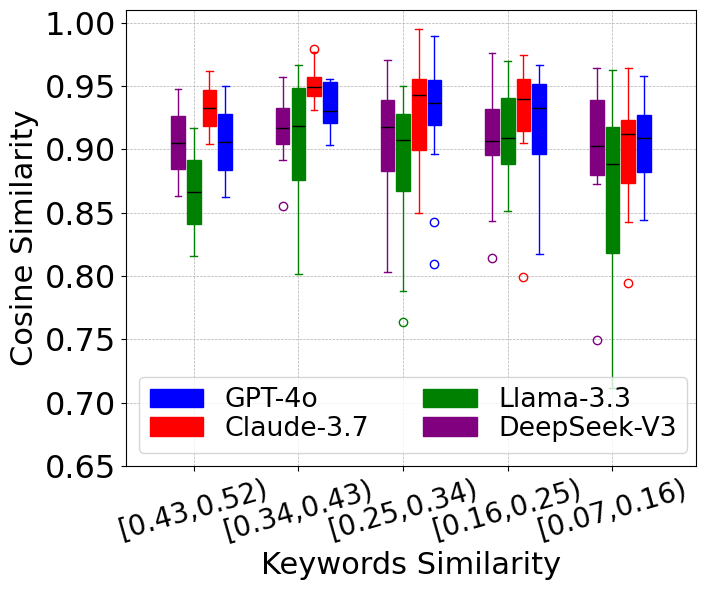

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

cols_to_plot = ['cos_gpt_1/2_ab_avg_selected',
                'cos_claude_1/2_ab_avg_selected',
                'cos_llama_1/2_ab_avg_selected',
                'cos_ds_1/2_ab_avg_selected']

colors = ['blue', 'red', 'green', 'purple', 'orange']

# Define bin edges
min_val = sorted_df_desc['keywords_sim_mean'].min() # 0.071
max_val = sorted_df_desc['keywords_sim_mean'].max() # 0.549
bins = np.arange(0.07, 0.55, 0.09)  # Ensure we cover the full range
sorted_df_desc['bin'] = pd.cut(sorted_df_desc['keywords_sim_mean'], bins, right=False)

plt.figure(figsize=(7.2, 6))

xticks = [f"[{b.left:.2f},{b.right:.2f})" for b in sorted_df_desc['bin'].cat.categories]
num_bins = len(bins) - 1
legend_patches = []

for idx, (col, color) in enumerate(zip(cols_to_plot, colors)):
    data_by_bin = []

    for b in sorted_df_desc['bin'].cat.categories:
        values = sorted_df_desc.loc[sorted_df_desc['bin'] == b, col].dropna()
        data_by_bin.append(values)

    # Offset positions
    positions = np.arange(num_bins) + (idx - len(cols_to_plot)/2) * 0.15
    plt.boxplot(data_by_bin, positions=positions, widths=0.13, patch_artist=True,
                boxprops=dict(facecolor=color, color=color),
                medianprops=dict(color='black'),
                whiskerprops=dict(color=color),
                capprops=dict(color=color),
                flierprops=dict(markeredgecolor=color))

    # Add to legend manually
    llm = col.replace('cos_', '').replace('_1/2_ab_avg_selected', '')
    if llm == 'claude':
        label = 'Claude-3.7'
    elif llm == 'llama':
        label = 'Llama-3.3'
    elif llm == 'gemini':
        label = 'Gemini-2.0'
    elif llm == 'gpt':
        label = 'GPT-4o'
    elif llm == 'ds':
        label = 'DeepSeek-V3'

    legend_patches.append(mpatches.Patch(color=color, label=label))

plt.xticks(np.arange(num_bins), xticks)
plt.xlabel('Keywords Similarity', fontsize = 22)
plt.ylabel('Cosine Similarity', fontsize = 22)
plt.xticks(fontsize = 20, rotation = 16)
plt.yticks(fontsize = 23)
plt.ylim(0.65, 1.01)

# plt.title('100 Samples: ambiguity hat(t2_a) vs hat(t2_ab)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(handles=legend_patches, loc='lower left', fontsize = 19.3, ncol=2, frameon=True, labelspacing=0.1)

#
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()